In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna import Trial
from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(
    "../input/10min/vcenter.csv", usecols=["date", "value"], parse_dates=["date"]
)
print(df.shape)
df.head()

(52151, 2)


,date,value
0,2020-02-19 09:00:00,10
1,2020-02-19 09:10:00,11
2,2020-02-19 09:20:00,11
3,2020-02-19 09:30:00,11
4,2020-02-19 09:40:00,11


In [3]:
df.rename(columns={"date": "ds", "value": "y"}, inplace=True)
df.tail()

,ds,y
52146,2021-02-17 08:10:00,29
52147,2021-02-17 08:20:00,28
52148,2021-02-17 08:30:00,28
52149,2021-02-17 08:40:00,29
52150,2021-02-17 08:50:00,29


In [4]:
train = df[df['ds'] < '2021-01-01']
valid = df[df['ds'] >= '2021-01-01']
print(train.shape)
print(valid.shape)

(45390, 2)
(6761, 2)


In [5]:
cap = np.max(train.y)
floor = np.min(train.y)

In [6]:
def objective(trial: Trial) -> float:
    params = {
        "changepoint_range": trial.suggest_discrete_uniform(
            "changepoint_range", 0.8, 0.95, 0.001
        ),
        "n_changepoints": trial.suggest_int("n_changepoints", 20, 35),
        "changepoint_prior_scale": trial.suggest_discrete_uniform(
            "changepoint_prior_scale", 0.001, 0.5, 0.001
        ),
        "seasonality_prior_scale": trial.suggest_discrete_uniform(
            "seasonality_prior_scale", 1, 25, 0.5
        ),
        "yearly_fourier": trial.suggest_int("yearly_fourier", 5, 15),
        "monthly_fourier": trial.suggest_int("monthly_fourier", 3, 12),
        "weekly_fourier": trial.suggest_int("weekly_fourier", 3, 7),
        "quaterly_fourier": trial.suggest_int("quaterly_fourier", 3, 10),
        "yearly_prior": trial.suggest_discrete_uniform("yearly_prior", 1, 25, 0.5),
        "monthly_prior": trial.suggest_discrete_uniform("monthly_prior", 1, 25, 0.5),
        "weekly_prior": trial.suggest_discrete_uniform("weekly_prior", 1, 25, 0.5),
        "quaterly_prior": trial.suggest_discrete_uniform("quaterly_prior", 1, 25, 0.5),
        "growth": "logistic",
        "seasonality_mode": "additive",
        "weekly_seasonality": True,
        "daily_seasonality": True,
    }
    # fit_model
    m = Prophet(
        changepoint_range=params["changepoint_prior_scale"],
        n_changepoints=params["n_changepoints"],
        changepoint_prior_scale=params["changepoint_prior_scale"],
        seasonality_prior_scale=params["seasonality_prior_scale"],
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=True,
        growth="logistic",
        seasonality_mode="additive",
    )
    m.add_seasonality(
        name="yearly",
        period=365.25,
        fourier_order=params["yearly_fourier"],
        prior_scale=params["yearly_prior"],
    )
    m.add_seasonality(
        name="monthly",
        period=30.5,
        fourier_order=params["monthly_fourier"],
        prior_scale=params["monthly_prior"],
    )
    m.add_seasonality(
        name="weekly",
        period=7,
        fourier_order=params["weekly_fourier"],
        prior_scale=params["weekly_prior"],
    )
    m.add_seasonality(
        name="quaterly",
        period=365.25 / 4,
        fourier_order=params["quaterly_fourier"],
        prior_scale=params["quaterly_prior"],
    )
    train["cap"] = cap
    train["floor"] = floor
    m.fit(train)
    future = m.make_future_dataframe(periods=365, freq="d")
    future["cap"] = cap
    future["floor"] = floor

    forecast = m.predict(future)
    valid_forecast = forecast.tail(7)

    val_mape = np.mean(np.abs((valid_forecast.yhat - valid.y) / valid.y)) * 100

    return val_mape

In [7]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=15)

[I 2021-04-10 18:37:08,865] A new study created in memory with name: no-name-2f965de7-22b8-4c64-b93b-ed041276545d
[I 2021-04-10 18:45:42,027] Trial 0 finished with value: 25.559082032739834 and parameters: {'changepoint_range': 0.8560000000000001, 'n_changepoints': 35, 'changepoint_prior_scale': 0.366, 'seasonality_prior_scale': 15.5, 'yearly_fourier': 6, 'monthly_fourier': 4, 'weekly_fourier': 3, 'quaterly_fourier': 9, 'yearly_prior': 15.5, 'monthly_prior': 18.0, 'weekly_prior': 1.5, 'quaterly_prior': 24.5}. Best is trial 0 with value: 25.559082032739834.
[I 2021-04-10 18:47:36,163] Trial 1 finished with value: 18.936345058780905 and parameters: {'changepoint_range': 0.925, 'n_changepoints': 23, 'changepoint_prior_scale': 0.091, 'seasonality_prior_scale': 5.0, 'yearly_fourier': 8, 'monthly_fourier': 8, 'weekly_fourier': 5, 'quaterly_fourier': 5, 'yearly_prior': 15.5, 'monthly_prior': 4.0, 'weekly_prior': 8.0, 'quaterly_prior': 9.5}. Best is trial 1 with value: 18.936345058780905.
[I 2

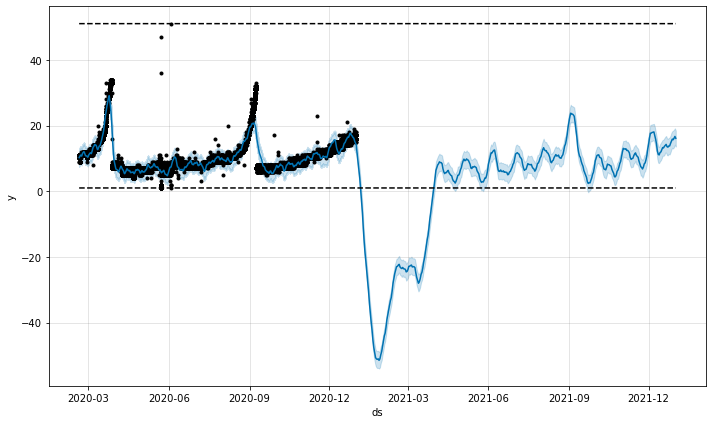

In [8]:
# fit_model
m = Prophet(
    changepoint_range=study.best_params["changepoint_prior_scale"],
    n_changepoints=study.best_params["n_changepoints"],
    seasonality_prior_scale=study.best_params["seasonality_prior_scale"],
    changepoint_prior_scale=study.best_params["changepoint_prior_scale"],
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    growth="logistic",
    seasonality_mode="additive",
)
m.add_seasonality(
    name="yearly",
    period=365.25,
    fourier_order=study.best_params["yearly_fourier"],
    prior_scale=study.best_params["yearly_prior"],
)
m.add_seasonality(
    name="monthly",
    period=30.5,
    fourier_order=study.best_params["monthly_fourier"],
    prior_scale=study.best_params["monthly_prior"],
)
m.add_seasonality(
    name="weekly",
    period=7,
    fourier_order=study.best_params["weekly_fourier"],
    prior_scale=study.best_params["weekly_prior"],
)
m.add_seasonality(
    name="quaterly",
    period=365.25 / 4,
    fourier_order=study.best_params["quaterly_fourier"],
    prior_scale=study.best_params["quaterly_prior"],
)

train["cap"] = cap
train["floor"] = floor
m.fit(train)
future = m.make_future_dataframe(periods=365, freq="d")
future["cap"] = cap
future["floor"] = floor

forecast = m.predict(future)
forecast_plot = m.plot(forecast)

In [9]:
cap = np.max(df.y)
floor = np.min(df.y)
df['cap'] = cap
df['floor'] = floor

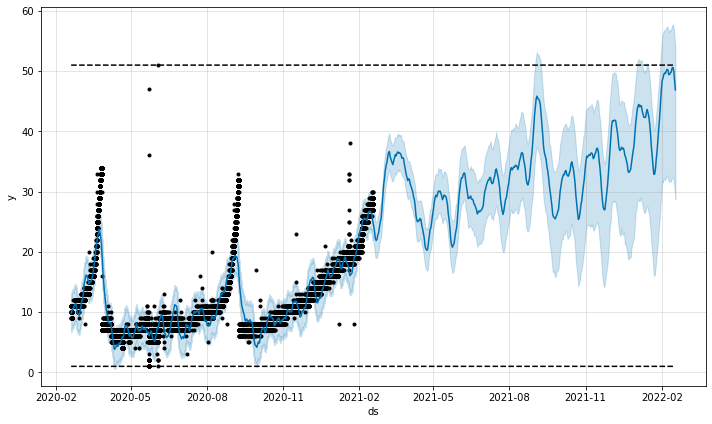

In [10]:
# fit_model
m = Prophet(
    changepoint_range=study.best_params["changepoint_prior_scale"],
    n_changepoints=study.best_params["n_changepoints"],
    seasonality_prior_scale=study.best_params["seasonality_prior_scale"],
    changepoint_prior_scale=study.best_params["changepoint_prior_scale"],
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    growth="logistic",
    seasonality_mode="additive",
)
m.add_seasonality(
    name="yearly",
    period=365.25,
    fourier_order=study.best_params["yearly_fourier"],
    prior_scale=study.best_params["yearly_prior"],
)
m.add_seasonality(
    name="monthly",
    period=30.5,
    fourier_order=study.best_params["monthly_fourier"],
    prior_scale=study.best_params["monthly_prior"],
)
m.add_seasonality(
    name="weekly",
    period=7,
    fourier_order=study.best_params["weekly_fourier"],
    prior_scale=study.best_params["weekly_prior"],
)
m.add_seasonality(
    name="quaterly",
    period=365.25 / 4,
    fourier_order=study.best_params["quaterly_fourier"],
    prior_scale=study.best_params["quaterly_prior"],
)

m.fit(df)

future = m.make_future_dataframe(periods=365, freq="d")
future['cap'] = cap
future['floor'] = floor
forecast1 = m.predict(future)
fig1 = m.plot(forecast1)